# Classify the topics with Title only with BERT

## Environment Setup

In [1]:
# Connect google drive into google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# install the latest version of transformers / version 3 of transformers

!pip install -q transformers
#!pip install transformers==3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.5 MB/s eta 0:00:00


In [3]:
# Enable GPU
# If not GPU is available, use CPU instead
import torch
if torch.cuda.is_available():
  print("cuda is available")
  device = torch.device("cuda")
else:
  print("cuda is not available")
  device = torch.device("cpu")

cuda is available


## Data Operation

In [4]:
# Import ml and nlp libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [5]:
# Setup the training and testing dataset file path before reading the data with pandas
train_data_path = '/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/train.csv'
test_data_path = '/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/test.csv'

In [6]:
# Read the first 5 training data
train_df = pd.read_csv(train_data_path)
train_df.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [7]:
# Obtain the number of data and the number of columns
train_df.shape

(20972, 9)

In [8]:
# Obtain the names of columns
train_df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [9]:
# Convert the prediction targets into list (to be more precise, it is vectors)
train_df['target_list'] = train_df[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values.tolist()

In [10]:
# Observe the converted results
train_df.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,target_list
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[1, 0, 0, 1, 0, 0]"


In [11]:
# Obtain the word count in the title of different article
# Observe the results afterwards
train_df['word_count'] = train_df['TITLE'].apply(lambda x: len(x.split()))
train_df.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,target_list,word_count
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]",4
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]",4
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",8
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",9
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[1, 0, 0, 1, 0, 0]",20


array([[<AxesSubplot:title={'center':'word_count'}>]], dtype=object)

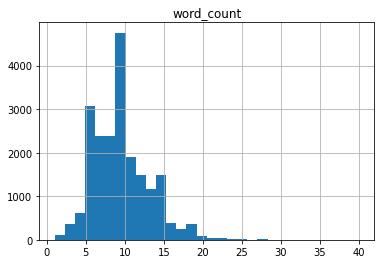

In [12]:
# Visualize the word_count in histogram
train_df.hist('word_count', bins=30)

In [13]:
# Obtain all the data we need
df = train_df[['TITLE', 'target_list']].copy()
df

,TITLE,target_list
0,Reconstructing Subject-Specific Effect Maps,"[1, 0, 0, 0, 0, 0]"
1,Rotation Invariance Neural Network,"[1, 0, 0, 0, 0, 0]"
2,Spherical polyharmonics and Poisson kernels fo...,"[0, 0, 1, 0, 0, 0]"
3,A finite element approximation for the stochas...,"[0, 0, 1, 0, 0, 0]"
4,Comparative study of Discrete Wavelet Transfor...,"[1, 0, 0, 1, 0, 0]"
...,...,...
20967,Contemporary machine learning: a guide for pra...,"[1, 1, 0, 0, 0, 0]"
20968,Uniform diamond coatings on WC-Co hard alloy c...,"[0, 1, 0, 0, 0, 0]"
20969,Analysing Soccer Games with Clustering and Con...,"[1, 0, 0, 0, 0, 0]"
20970,On the Efficient Simulation of the Left-Tail o...,"[0, 0, 1, 1, 0, 0]"


## Setup model

In [14]:
# Config of models

'''
MAX_LEN: the length that BERT can read, should not exceed 512
TRAIN_BATCH_SIZE: the length that training dataset can take
VALID_BATCH_SIZE: the length that valid dataset can take
EPOCHS: training epochs
LEARNING RATE: learning rate of the model
tokenzier(分詞器): the tools used to separate the vocab in the sentence
'''
MAX_LEN = 16
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4 
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
# Create CustomDataset Class to generate tensors from raw input features and output the class of Pytorch Tensors
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['TITLE']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
# Split the training dataset to training and validation dataset
# Training dataset: Validation dataset = 80: 20
train_size = 0.8
train_dataset = df.sample(frac=train_size, random_state=200)
valid_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20972, 2)
TRAIN Dataset: (16778, 2)
TEST Dataset: (4194, 2)


In [17]:
# Convert the datasets to tensors
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [18]:
# Build a BERT model for training and prediction
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased') --> Use when you used v3 of transformers
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3) # Dropout is used to avoid overfitting
        self.l3 = torch.nn.Linear(768, 6) # Returns 6 features, which are the final predictions of target list
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [19]:
# Define Loss Functions and optimizer
# BCE Logistic Loss: find out error between predicted values from model and actual target values
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [20]:
# Create checkpoint 
# Save time to retrain from beginning
# Save the best model

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item() 

In [21]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## Training and evaluation

In [24]:
val_targets = []
val_outputs = []

In [25]:
# Train the model
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [26]:
# TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str
# Check with stackoverflow, it should be version issue
# Solution 1: Downgrade the version of transformers from 4 to 3 to avoid
# Solution 2: BERTModel.from_pretrained add return_dict=False
# https://stackoverflow.com/questions/65082243/dropout-argument-input-position-1-must-be-tensor-not-str-when-using-bert

checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/checkpoint/current_checkpoint.pt'
best_model = '/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/best_model/best_model.pt'
trained_model = train_model(1, 4, np.Inf, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000448 	Average Validation Loss: 0.001804
Validation loss decreased (inf --> 0.001804).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000388 	Average Validation Loss: 0.001776
Validation loss decreased (0.001804 --> 0.001776).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [27]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [29]:
# Evaluate Model Performance (accuracy, precision, recall, f1-measure)
accuracy = metrics.accuracy_score(val_targets, val_preds)
precision_score_micro = metrics.precision_score(val_targets, val_preds, average='micro')
precision_score_macro = metrics.precision_score(val_targets, val_preds, average='macro')
recall_score_micro = metrics.recall_score(val_targets, val_preds, average='micro')
recall_score_macro = metrics.recall_score(val_targets, val_preds, average='macro')
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')

In [31]:
print(f"Accuracy Score = {accuracy}")
print(f"Precision Score (Micro) = {precision_score_micro}")
print(f"Precision Score (Macro) = {precision_score_macro}")
print(f"Recall Score (Micro) = {recall_score_micro}")
print(f"Recall Score (Macro) = {recall_score_macro}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6026466380543634
Precision Score (Micro) = 0.7800277943220171
Precision Score (Macro) = 0.7400505665088194
Recall Score (Micro) = 0.7473844397945596
Recall Score (Macro) = 0.6180282182733067
F1 Score (Micro) = 0.7633572955119486
F1 Score (Macro) = 0.6609300197093172


In [32]:
# Use confusion metrix and classificaion report to visualize the model predict correctly/incorrectly for each individual target
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

cm_labels = ['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']
    
cm = mcm(val_targets, val_preds)

print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      6952
           1       0.88      0.78      0.83      4680
           2       0.77      0.73      0.75      4496
           3       0.69      0.73      0.71      4208
           4       0.65      0.30      0.41       524
           5       0.66      0.38      0.48       168

   micro avg       0.78      0.75      0.76     21028
   macro avg       0.74      0.62      0.66     21028
weighted avg       0.78      0.75      0.76     21028
 samples avg       0.79      0.78      0.77     21028



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

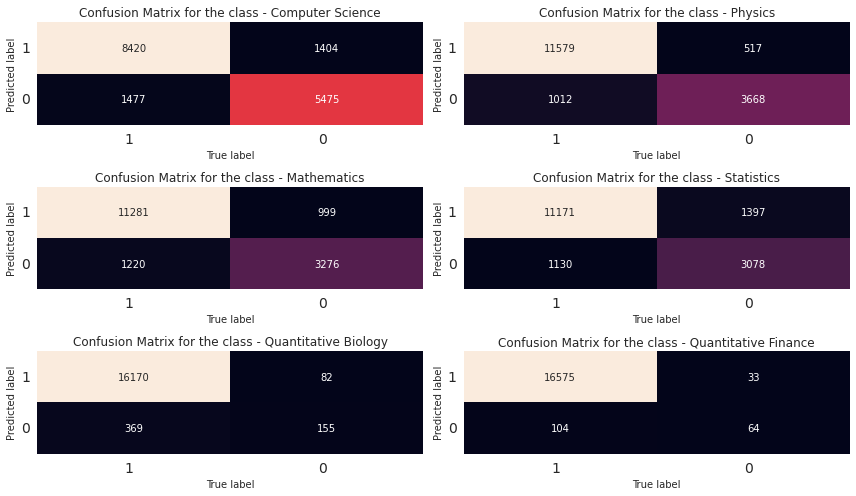

In [34]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()

## Predict with testing dataset

In [35]:
test_df = pd.read_csv(test_data_path)
test_df

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...
...,...,...,...
8984,29957,Supporting mixed-datatype matrix multiplicatio...,We approach the problem of implementing mixe...
8985,29958,An axiomatic basis for Blackwell optimality,In the theory of Markov decision processes (...
8986,29959,GeneVis - An interactive visualization tool fo...,GeneVis is a web-based tool to visualize com...
8987,29960,Quantifying the causal effect of speed cameras...,This paper quantifies the effect of speed ca...


In [36]:
test_df.shape

(8989, 3)

In [37]:
# Convert the text to Pytorch tensor
class PrepForPredictionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['TITLE']
        #self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
           # 'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [38]:
testing_set = PrepForPredictionDataset(test_df, tokenizer, MAX_LEN)
testing_set[0]

{'ids': tensor([  101,  2701,  1011,  2433, 14785, 16593,  1999, 13091,  1011, 13433,
         24077,  8185,  5387,  3989,   102,     0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [39]:
testing_loader = DataLoader(testing_set, **test_params)

In [40]:
def do_prediction(loader):
    model.eval()
   
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            #fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [42]:
pred_outputs = do_prediction(testing_loader)
pred_outputs

[[0.33954063057899475,
  0.009900718927383423,
  0.17153771221637726,
  0.9785706400871277,
  0.01346525363624096,
  0.01232156716287136],
 [0.012746934778988361,
  0.9912211894989014,
  0.011685127392411232,
  0.010073334909975529,
  0.0063926298171281815,
  0.0049909502267837524],
 [0.9679468870162964,
  0.13244299590587616,
  0.020828938111662865,
  0.02877959981560707,
  0.0090536680072546,
  0.0022660463582724333],
 [0.013013811782002449,
  0.9916513562202454,
  0.010757040232419968,
  0.01043516956269741,
  0.007148424629122019,
  0.005528745241463184],
 [0.9502633810043335,
  0.020258037373423576,
  0.08083067834377289,
  0.11911175400018692,
  0.005315703339874744,
  0.0065802293829619884],
 [0.14611577987670898,
  0.014448156580328941,
  0.7553467154502869,
  0.9690189361572266,
  0.013667957857251167,
  0.016216794028878212],
 [0.043436240404844284,
  0.0721675455570221,
  0.610565185546875,
  0.950838565826416,
  0.010800725780427456,
  0.01627584919333458],
 [0.060312721878

In [43]:
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)
pred_outputs

array([[0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [44]:
# Convert the pred_outputs to the sample_submission.csv
preds_df = pd.DataFrame(pred_outputs, columns=['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'])
preds_df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0,0,0,1,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0


In [45]:
# axis=1 --> columns
df_concat = pd.concat([test_df, preds_df], axis=1)
df_concat.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,0,0,0,1,0,0
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,0,1,0,0,0,0
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,1,0,0,0,0,0
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,0,1,0,0,0,0
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,1,0,0,0,0,0


In [46]:
'''
final_df = df_concat[['ID','Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']]
'''
final_df = df_concat.drop(columns=["TITLE", "ABSTRACT"])
final_df

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0
...,...,...,...,...,...,...,...
8984,29957,1,0,0,1,0,0
8985,29958,0,0,1,0,0,0
8986,29959,0,0,0,1,0,0
8987,29960,1,0,0,1,0,0


In [47]:
final_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/Outputs/titles_only.csv', encoding='utf8', index=0)